In [1]:
#%matplotlib widget
from copy import deepcopy
import gym
from dqn2 import dqn, Model, AggregateModel
from utils2 import linear_decay_clip, plot_2d_value_function, test_env
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### Load CartPole

In [2]:
env = gym.make('CartPole-v1')

In [3]:
n_features = env.observation_space.shape[0]
n_actions = env.action_space.n
lows = env.observation_space.low
highs = env.observation_space.high
print(f'There are {n_features} features & {n_actions} actions')
lows[[1,3]] = -1
highs[[1,3]] = 1
print(lows)
print(highs)

There are 4 features & 2 actions
[-4.8        -1.         -0.41887903 -1.        ]
[4.8        1.         0.41887903 1.        ]


### Naive Q-Learning

In [1]:
model = AggregateModel(lows, highs, 10, n_actions, 0.1)

NameError: name 'AggregateModel' is not defined

In [ ]:
model, history = dqn(
    env=env, gamma=0.9, epsilon=linear_decay_clip(1, 0.1, 50000),
    model=model, capacity=1, warmup_steps=0, train_steps=100000,
    update_steps=1, batch_size=1)

In [75]:
model, history = dqn(
    env=env, gamma=0.9, epsilon=linear_decay_clip(0.1, 0.01, 50000),
    model=model, capacity=1, warmup_steps=0, train_steps=100000,
    update_steps=1, batch_size=1)

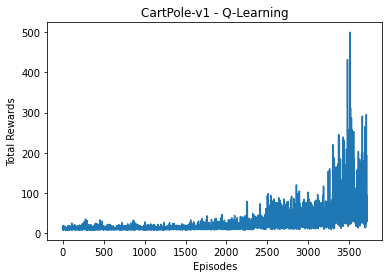

In [73]:
%matplotlib inline
plt.plot(range(len(history['eps_rewards'])), history['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('CartPole-v1 - Q-Learning')
plt.show()

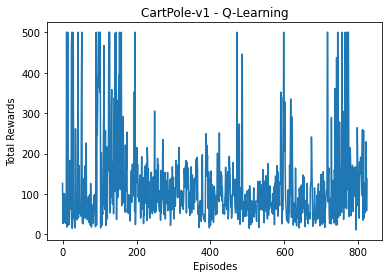

In [76]:
%matplotlib inline
plt.plot(range(len(history['eps_rewards'])), history['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('CartPole-v1 - Q-Learning')
plt.show()

In [77]:
test_env(env, delay=0.1, action_func=lambda state: np.argmax(model.q_values(state)))

180


### DQN

In [194]:
class SampleModel(Model, nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, n_actions)
        self.opt = optim.Adam(self.parameters(), lr=0.005)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def q_values(self, state):
        x = torch.tensor(state, dtype=torch.float)
        with torch.no_grad():
            q_values = self.forward(x)
        return q_values.numpy()
    def update(self, states, actions, targets):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.long)
        targets = torch.tensor(targets, dtype=torch.float)
        ds = TensorDataset(states, actions, targets)
        dl = DataLoader(ds, batch_size=1)
        acc_loss = 0
        for states, actions, targets in dl:
            q_values_pred = self.forward(states)
            q_values_true = q_values_pred.detach().clone()
            q_values_true[range(len(states)), actions] = targets
            loss = F.mse_loss(q_values_pred, q_values_true)
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            acc_loss += loss.item() * len(states)
        return acc_loss / len(ds)
    def copy(self):
        return deepcopy(self)

In [236]:
model2 = SampleModel()

In [247]:
model2, history2 = dqn(
    env=env, gamma=1, epsilon=linear_decay_clip(0.1, 0.01, 10000),
    model=model2, capacity=5000, warmup_steps=5000, train_steps=100000,
    update_steps=2000, batch_size=1)

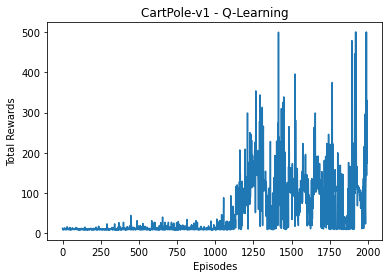

In [238]:
%matplotlib inline
plt.plot(range(len(history2['eps_rewards'])), history2['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('CartPole-v1 - Q-Learning')
plt.show()

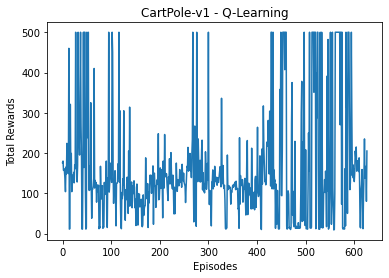

In [241]:
%matplotlib inline
plt.plot(range(len(history2['eps_rewards'])), history2['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('CartPole-v1 - Q-Learning')
plt.show()

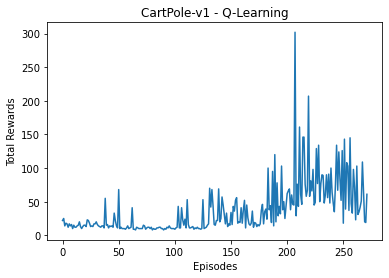

In [148]:
%matplotlib inline
plt.plot(range(len(history2['eps_rewards'])), history2['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('CartPole-v1 - Q-Learning')
plt.show()

In [249]:
test_env(env, delay=0.01, action_func=lambda state: np.argmax(model.q_values(state)))

86
